# Audio Matching

In this homework you will implement an audio matching system that can recognize a live performance of classical music.

I have provided a skeleton of the code below, and you will fill in any sections marked with `### START CODE BLOCK ###` and `### END CODE BLOCK ###`.  Please do not change the code outside of these markers.  In particular, do not define any new functions, change the code decomposition, or modify function inputs, outputs, or default values.  Note that this code is written for ease of understanding and ease of grading, not for efficiency.

Once you have completed this assignment, please run all cells in your notebook, make sure that all plots, images, and outputs are embedded in the notebook, and then submit your .ipynb file on Gradescope.

Partner 1 Name: Dan Fonseca

Number of hours spent (Partner 1): __________

Partner 2 Name: Patrick Liu

Number of hours spent (Partner 2): __________


In [66]:
%matplotlib inline

In [67]:
import numpy as np
import librosa as lb # for reference, my solutions use librosa version 0.7.2
import matplotlib.pyplot as plt
from scipy.signal import stft
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
from collections import defaultdict
#import hw4_solns

In [68]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

### Extracting Chroma Features (30 points)

In this first part you will implement a function that extracts chroma features.

In the extractChromaFeatures function, you should:
- load the audio using librosa.core.load
- calculate the STFT using scipy.signal.stft
- compute the squared magnitude of STFT coefficients
- determine the log frequency conversion matrix by calling getLogFreqConversionMatrix()
- determine the chroma conversion matrix by calling getChromaConversionMatrix()
- compute chroma features by applying the chroma conversion matrix
- apply element-wise logarithmic compression by calling logCompression()
- L2 normalize each column by calling normL2()

In [69]:
def extractChromaFeatures(mp3file, sr = 22050, winsize = 2048, hop = 512, gamma = 10000):
    '''
    Compute chroma feature matrix on a specified audio file.
    
    Arguments:
    mp3file -- path to mp3 file
    sr -- desired sampling rate in Hz
    winsize -- analysis window size in samples
    hop -- hop size in samples
    gamma -- coefficient used in log compression
    
    Returns:
    F -- chroma feature matrix of size (12, M), where M is the number of audio frames.  The
         features have logarithmic compression and each column is L2 normalized.
    '''
    ### START CODE BLOCK ###
    audio, sr = lb.load(mp3file, sr=sr)
    f, t, audio_stft = stft(audio, nperseg=winsize, noverlap=winsize-hop)
    audio_stft_mag = np.abs(audio_stft)
    audioLog = getLogFreqConversionMatrix(winsize, sr)
    audioChroma = getChromaConversionMatrix(audioLog)
    chroma_matrix = np.matmul(audioChroma, audio_stft_mag)
    chroma_matrix = logCompression(chroma_matrix, gamma)
    F = normL2(chroma_matrix)

    ### END CODE BLOCK ###
    return F

To calculate the log frequency spectrogram Slog, we can simply pre-multiply the one-sided spectrogram S with a matrix B.  If S has dimensions (N/2)+1 rows by M columns, then B will have 128 rows by (N/2)+1 columns.

In the getLogFreqConversionMatrix function, you should:
- determine the lower and upper bound in Hz for each pitch band for p=0, 1, ..., 127
- determine the DFT indices that fall within the lower and upper bounds for each pitch value
- set the appropriate indices in B to construct the log frequency conversion matrix

Note that B will be a binary matrix containing only zeros and ones.

In [70]:
def getLogFreqConversionMatrix(N, fs):
    '''
    Determine the log frequency conversion matrix that can be used to pre-multiply a one-sided spectrogram
    to get a log frequency spectrogram.
    
    Arguments:
    N -- analysis window size
    fs -- sampling rate
    
    Returns:
    B -- a binary matrix of shape (128, (N/2)+1).  The log frequency spectrogram can be computed
         by computing the matrix product of B and the spectrogram matrix.
    '''
    numBins = int(N/2) + 1
    pitchMax = 128
    B = np.zeros((pitchMax, numBins))
    p = np.arange(pitchMax)

    ### START CODE BLOCK ###
    for pitch in p:
          uppBound = 440 * 2**((pitch + 1/2 - 69)/12)
          lowBound = 440 * 2**((pitch - 1/2 - 69)/12)
          for k in range(numBins):
               k_freq = k * (fs / N)
               if k_freq >= lowBound and k_freq < uppBound:
                    B[pitch, k] = 1

    ### END CODE BLOCK ###

    return B

In [71]:
rand_arr = np.random.rand(5, 5)
rand_arr
f, x, rand_arr_stft = stft(rand_arr, nperseg=2)

In [72]:
rand_arr_stft_mag = np.abs(rand_arr_stft)

In [73]:
rand_arr_stft_mag

array([[[0.20571457, 0.6898216 , 0.19519011, 0.70200524, 0.30019574,
         0.        ],
        [0.20571457, 0.6898216 , 0.19519011, 0.70200524, 0.30019574,
         0.        ]],

       [[0.7546421 , 0.9143285 , 0.60884923, 0.44964925, 0.44794494,
         0.        ],
        [0.7546421 , 0.9143285 , 0.60884923, 0.44964925, 0.44794494,
         0.        ]],

       [[0.83066056, 0.2950492 , 0.6567207 , 0.44999705, 0.89422608,
         0.        ],
        [0.83066056, 0.2950492 , 0.6567207 , 0.44999705, 0.89422608,
         0.        ]],

       [[0.55279806, 0.77336473, 0.90316363, 0.22027529, 0.04973566,
         0.        ],
        [0.55279806, 0.77336473, 0.90316363, 0.22027529, 0.04973566,
         0.        ]],

       [[0.75157131, 0.08451326, 0.82137806, 0.67848384, 0.61823471,
         0.        ],
        [0.75157131, 0.08451326, 0.82137806, 0.67848384, 0.61823471,
         0.        ]]])

To calculate chroma features, we can simply pre-multiply the one-sided spectrogram S with a matrix W.  If S has dimension (N/2)+1 rows by M columns, then W will have 12 rows by M columns.  The matrix W can be computed by collapsing appropriate rows in the log frequency conversion matrix B.

In the getChromaConversionMatrix, you should:
- initialize W to the appropriate size
- for each chroma value, sum across constituent pitch values

Note that W will be a binary matrix containing only zeros and ones.

In [74]:
def getChromaConversionMatrix(B):
    '''
    Determine the chroma conversion matrix that can be used to pre-multiply a one-sided spectrogram
    to calculate chroma features.
    
    Arguments:
    B -- log frequency conversion matrix
    
    Returns:
    W -- a binary matrix with 12 rows and the same number of columns as B.  Chroma features can be computed
         as the matrix product of W and the spectrogram matrix.
    '''
    
    ### START CODE BLOCK ###
    numBins = B.shape[1]
    W = np.zeros((12, numBins)) # 12 pitches per octave
    
    # Loop over all 128 pitches (B.shape(0))
    for pitch in range(B.shape[0]):
        chroma = pitch % 12
        W[chroma, :] += B[pitch, :]
    
    W[W>0] = 1   # why doing this
         
    ### END CODE BLOCK ###ffgdcdcfgbvcfgbvb

    return W

In the logCompression function, you should:
- apply logarithmic compression ln(1 + gamma * c) to each element c.  Note that the log is with base e.

In [75]:
def logCompression(F, gamma = 10000):
    '''
    Apply element-wise logarithmic compression.
    
    Arguments:
    F -- input matrix
    gamma -- scalar that controls the level of compression as ln(1 + gamma * c)
    
    Returns:
    Fc -- matrix of logarithmically compressed values.  Fc is of the same size as F.
    '''
    
    ### START CODE BLOCK ###
    Fc = np.log(1+F*gamma)
    
    ### START CODE BLOCK ###

    return Fc

In the normL2 function, you should:
- normalize each column of a matrix to have unit L2 norm

Make sure to implement this in a vectorized way.  Also, you will want to add a small epsilon (e.g. `1e-9`) to the denominator in case you have a column of all zeros.

In [76]:
def normL2(F):
    '''
    Normalize each column of a matrix to have unit L2 norm.
    
    Arguments:
    F -- input feature matrix where each column corresponds to a single feature vector
    
    Returns:
    Fnorm -- normalized feature matrix of the same shape as F, where each column has been
             been normalized to be unit L2 norm
    '''
    ### START CODE BLOCK ###

    norms = np.sqrt(np.sum(F**2, axis=0)) + 1e-9
    Fnorm = F/norms
    
    ### END CODE BLOCK ###
    
    return Fnorm

Here are some sample outputs to use for debugging and verifying that your implementation is correct.

In [77]:
B = getLogFreqConversionMatrix(2048, 22050)
B[64,25:35]

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0.])

In [78]:
C = getChromaConversionMatrix(B)
C[0,0:30]

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.])

In [79]:
logCompression(np.arange(9).reshape((3,3)))

array([[ 0.        ,  9.21044037,  9.90353755],
       [10.30898599, 10.59665973, 10.81979828],
       [11.00211651, 11.15626481, 11.28979441]])

array([[ 0.        ,  9.21044037,  9.90353755],
       [10.30898599, 10.59665973, 10.81979828],
       [11.00211651, 11.15626481, 11.28979441]])

In [80]:
T = normL2(np.random.randn(5,10))
np.sum(T * T, axis = 0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

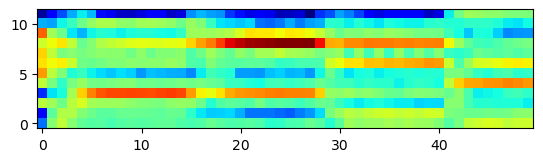

In [81]:
F = extractChromaFeatures('queries/chopin_alternate_query.mp3')
plt.imshow(F[:,0:50], cmap = 'jet', origin = 'lower')
plt.show()

<img src="figs/sampleChroma.png">

### Constructing Database (5 points)

In this part you will construct the database of features.

In the constructDB function, you should:
- create a python dictionary that will contain the database
- iterate through the mp3 files in the specified directory using glob.glob
- extract chroma features from each file
- store the chroma feature matrix in the dictionary, where the dictionary key is a string specifying the piece name and the value is a feature matrix

In [82]:
def constructDB(indir):
    '''
    Constructs a database containing the feature matrices for all reference tracks.
    
    Arguments:
    indir -- directory containing the mp3 files to store in the database
    
    Returns:
    db -- a dictionary where the key is the name of the piece and the value is its chroma feature matrix
    '''
    db = defaultdict(list)
    mp3_path = f'{indir}/*.mp3'
    mp3_files = glob.glob(mp3_path)
    
    ### START CODE BLOCK ###
    for file in mp3_files:
        file_name = os.path.basename(file)
        file_chroma = extractChromaFeatures(file)
        db[file_name] = file_chroma
    
    ### END CODE BLOCK ###
    
    return db

Now let's call the constructDB function and save the database to file using `pickle.dump` for later use.  Note that this may take about a minute to run.

In [83]:
### START CODE BLOCK ###
ref_dir = 'references'
db = constructDB(ref_dir)
# print(db)
### END CODE BLOCK ###

[src/libmpg123/id3.c:process_comment():587] error: No comment text / valid description?
[src/libmpg123/id3.c:INT123_id3_to_utf8():394] warning: Weird tag size 87 for encoding 1 - I will probably trim too early or something but I think the MP3 is broken.


Let's save the database to file for convenient access later.

In [84]:
with open('db.pkl','wb') as f:
    pickle.dump(db, f)

### Subsequence DTW (35 points)

In this part you will implement functions necessary to run subsequence DTW.  The tasks you must complete are:
- implement the computeCostMatrix_costdist function
- implement the subsequenceDTW function
- compare the output of your function to librosa.core.dtw to verify that they match on a single example
- plot the cost matrix and overlay the predicted alignment path for a single example
- listen to the query and predicted matching segment of the reference to verify that the alignment was done correctly
- calculate the ratio between the query audio length and the matching segment length

Please make sure to include all work in your notebook to get full credit!

In the computeCostMatrix_cosdist function, you should:
- compute the cosine distance cost matrix C

In [85]:
def computeCostMatrix_cosdist(Fquery,Fref):
    '''
    Computes the cosine distance cost matrix.
    
    Arguments:
    Fquery -- the query chroma feature matrix of dimension (12, # query frames), this feature
              matrix is assumed to be L2 normalized
    Fref -- the reference feature matrix, of dimension (12, # reference frames), this feature
            matrix is assumed to be L2 normalized
    
    Returns:
    C -- cost matrix whose (i,j)th element specifies the cosine distance between the i-th query frame
         and the j-th reference frame
    '''
    
    ### START CODE BLOCK ###
    mul = np.dot(Fquery.T, Fref)
    identity = np.ones(mul.shape)
    C = identity - mul
    ### START CODE BLOCK ###

    return C

In the subsequenceDTW function, you should:
- initialize the cumulative cost matrix D and backtrace matrix B
- compute the values in D and B using dynamic programming
- call the `backtrace` function to determine the optimal path
- construct the optimal subsequence path

In [158]:
def subsequenceDTW(C, steps, weights):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.zeros(C.shape)
    B = np.zeros(C.shape, dtype=np.int8)

    ### START CODE BLOCK ###
    m, n = C.shape
    D[0,:] = C[0,:]
    D[1:, :] = np.inf
    
    for i in range (1, m):
        for j in range (n):
            min_cost = np.inf
            for idx, (x_step, y_step) in enumerate(steps):
                    prev_i, prev_j = i-x_step, j-y_step
                    if prev_i >= 0 and prev_j >= 0:
                         cost = D[prev_i, prev_j] + C[i,j]*weights[idx]
                         if cost < min_cost:
                              min_cost = cost
                              B[i, j] = idx
            if min_cost != np.inf:
                D[i, j] = min_cost


    optcost = np.min(D[-1, :]) # minimum value in the last row
    # print(D)
    path = backtrace(D, B, steps)
    
    ### END CODE BLOCK ###
    
    path = np.array(path)
    
    return optcost, path

In the backtrace function, you should:
- determine the coordinate of the ending point on the optimal path
- follow the backtrace pointers and append each coordinate to `path`
- return a list of the coordinates in the optimal subsequence path

In [159]:
def backtrace(D, B, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''

    path = []

    ### START CODE BLOCK ###
    x_coordinate, y_coordinate = D.shape[0]-1, np.argmin(D[-1,:])

    while x_coordinate >= 0 and y_coordinate >= 0:
        path.append((x_coordinate, y_coordinate))
        
        step_idx = B[x_coordinate, y_coordinate] 
        x_step, y_step = steps[step_idx]
        x_coordinate -= x_step
        y_coordinate -= y_step 
    

    ### END CODE BLOCK ###
    
    return path

To check if your implementation is correct, verify that your function's output matches the output of librosa.core.dtw on the following example (please do not change the parameters below).

In [160]:
queryfile = 'queries/beethoven_alternate_query.mp3'
reffile = 'references/beethoven.mp3'
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [1,1,1]

In [161]:
Fquery = extractChromaFeatures(queryfile)
Fref = extractChromaFeatures(reffile)

In [162]:
D, wp = lb.sequence.dtw(X=Fquery, Y=Fref, step_sizes_sigma=steps, weights_mul=weights, metric = 'cosine', subseq=True)
wp[-5:], np.min(D[-1,:])

(array([[   8, 2918],
        [   6, 2917],
        [   4, 2916],
        [   2, 2915],
        [   0, 2914]]),
 1.8576943526977634)

In [163]:
# run your own implementation of subsequence DTW and verify that the outputs match

### START CODE BLOCK ###
costMatrix = computeCostMatrix_cosdist(Fquery, Fref)

# costMatrix = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
# costMatrix = costMatrix.reshape((3, 4))
# print(costMatrix)
# print("--"*40)
optcost, path = subsequenceDTW(costMatrix, steps, weights)
path[-5:], optcost

### END CODE BLOCK ###

(array([[   8, 2918],
        [   6, 2917],
        [   4, 2916],
        [   2, 2915],
        [   0, 2914]]),
 1.85771836600043)

Display the cost matrix as an image and overlay the predicted alignment.

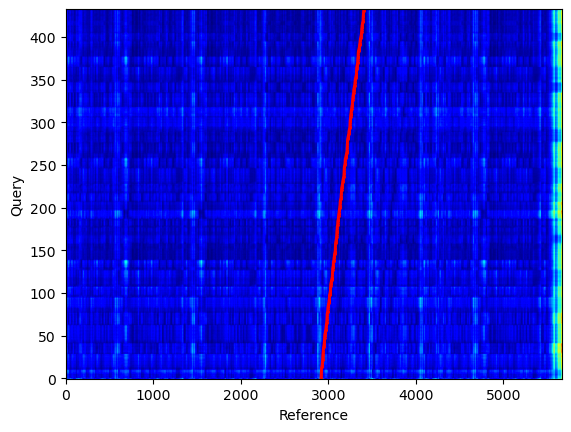

In [183]:
### START CODE BLOCK ###
plt.xlabel('Reference')
plt.ylabel('Query')
x, y = zip(*path) 
plt.plot(y, x, '-o', color='red', markersize=1, linewidth=2)
# plt.xlim(2800, 3500)
plt.imshow(costMatrix, origin='lower', cmap='jet', aspect='auto')# 
### END CODE BLOCK ###

Listen to the query and the predicted matching segment of the reference.  You can use IPython.display.Audio

In [93]:
# listen to query

### START CODE BLOCK ###

### END CODE BLOCK ###

In [94]:
# listen to matching segment of reference

### START CODE BLOCK ###

### END CODE BLOCK ###

Calculate the ratio of the query length to the matching segment length.  This gives an overall sense of how similar or different the tempos are.

In [95]:
### START CODE BLOCK ###

### END CODE BLOCK ###

### Benchmark (15 points)

In this part you will put all the pieces together to implement an audio matching system and measure its accuracy.  You must do the following:
- implement runBenchmark function
- run the benchmark and display the accuracy of your system

In the runBenchmark function, you should:
- iterate through the query files in the specified directory
- extract features on the query
- compute the match score of each piece in the database using subsequence DTW
- check if the predicted piece is correct

To speed up your experiment, you may use `lb.sequence.dtw` in place of your own subsequenceDTW implementation.  You should compute the cost matrix using your `computeCostMatrix_cosdist` function, and then pass the cost matrix to `lb.sequence.dtw`.

In [96]:
def runBenchmark(d, indir, steps, weights, shorten = None):
    '''
    Runs a benchmark on a given set of queries and returns the accuracy of the system.
    
    Arguments:
    d -- database of chroma feature matrices
    indir -- directory containing query mp3 files
    steps -- matrix specifying allowable transitions in the subsequence DTW, size (L, 2)
    weights -- vector of length L specifying the multiplicative weights of each transition
    shorten -- a float between 0 and 1 specifying what fraction of the query to use.  For example, 
               when shorten = .5, only the first 50% of the features will be used.
               
    Returns:
    accuracy -- the fraction of queries that were identified correctly
    '''

    ### START CODE BLOCK ###
    
    ### END CODE BLOCK ###
    
    return accuracy

Now run the benchmark and print out the system accuracy.

In [97]:
### START CODE BLOCK ###

### END CODE BLOCK ###

### Analysis (15 points)

In this part you will run additional experiments to gain more intuition about how subsequence DTW works.  You should do the following:
- Run a set of experiments that varies two different parameters: the length of the audio query and the DTW transition weights.  The allowable transitions should be fixed to {(1,1), (1,2), (2,1)}.
- Create a plot that shows how accuracy changes for the following query lengths: 3 sec, 2 sec, 1 sec, .75 sec, .5 sec, .25 sec.  Your plot should also compare the following two weighting schemes: `{1,1,1}` and `{1,1,2}`.  This will require you to run your benchmark 12 times with different settings.
- Describe which weighting scheme is better for very short queries and provide an intuitive explanation for why that weighting scheme should be better.

In [98]:
# run series of benchmarks

### START CODE BLOCK ###

### END CODE BLOCK ###

In [99]:
# create plot of results

### START CODE BLOCK ###

### END CODE BLOCK ###